Ra1E+05_Pr1E+00
Ra1E+06_Pr1E+00
Ra1E+07_Pr1E+00
Ra1E+08_Pr1E+00
Ra1E+09_Pr1E+00
Ra1E+10_Pr1E+00
Ra1E+11_Pr1E+00
Ra1E+12_Pr1E+00
0.9989694206891346


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


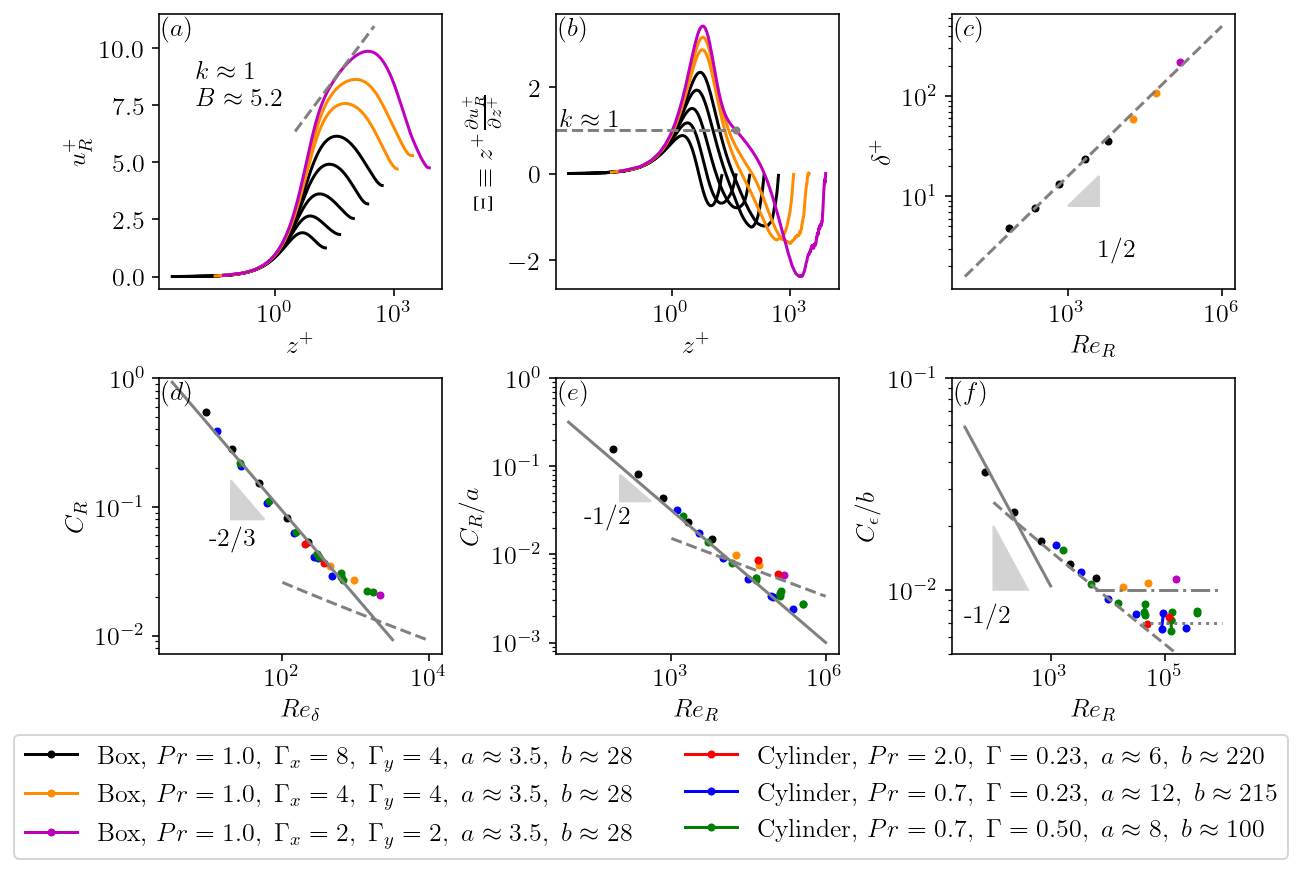

In [4]:
import os
import numpy as np
import scipy.integrate as intg
import scipy.optimize as sopt
import h5py
import matplotlib.pyplot as pl
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgba

from matplotlib import rc
rc('font',**{'family':'STIXGeneral','serif':['stix'],'size':13})
rc('text', usetex=True)

################################################################

def CF2RE(Cf,kappa=0.41,B=5):

    Aa = (2/Cf)**0.5
    Kk = kappa*(Aa-B)

    return(2*Aa*np.exp(Kk))

def RE2CF(Re,kappa=0.41,B=5,iter=1E4,residual=1E-8,verbose=False):

    Nn = int(np.log10(iter))+1

    # Initial guess
    Cf = 0.060*Re**(-0.25)

    for i in range(int(iter)):
        Aa = (2/Cf)**0.5
        Ik = 1/kappa
        Nr = (Ik*np.log(0.5*Re/Aa)) + B - Aa
        Dr = 0.25*Aa*((Ik*Aa) + (Aa*Aa))
        Cc = Cf - Nr/Dr
        L2 = (np.mean((Cc-Cf)**2))**0.5
        Cf = Cc 
        if verbose: print('Iteration {:{Nn}d}, Residual = {}'.format(i,L2,Nn=int(np.log10(iter))+1))
        if (L2<residual): break
        return(Cf)

################################################################  

fig,axs = pl.subplots(2,3,figsize=(8.25,5),constrained_layout=True)

###################################################################################################

rootdir = "../raw_data/RBP"

Cases = [
    'Ra1E+05_Pr1E+00',
    'Ra1E+06_Pr1E+00',
    'Ra1E+07_Pr1E+00',
    'Ra1E+08_Pr1E+00',
    'Ra1E+09_Pr1E+00',
    'Ra1E+10_Pr1E+00',
    'Ra1E+11_Pr1E+00',
    'Ra1E+12_Pr1E+00'
]
Colors = ['k','k','k','k','k','darkorange','darkorange','m']

for i,(Case,Color) in enumerate(zip(Cases,Colors)):
    stafield = h5py.File('{}/{}/stafield_master.h5'.format(rootdir,Case),'r')
    
    Ra = stafield['Rayleigh Number'][0]
    Pr = stafield['Prandtl Number'][0]

    nueff = (Pr/Ra)**0.5

    xm    = stafield['xm'][:]

    avg_t = stafield['temp_m1'][0]

    vy_m2 = stafield['vy_m2'][:]/avg_t
    vy_m2 = 0.5*(vy_m2 + np.flip(vy_m2))

    vz_m2 = stafield['vz_m2'][:]/avg_t
    vz_m2 = 0.5*(vz_m2 + np.flip(vz_m2))

    vh_m2 = vy_m2 + vz_m2
    vh_m1 = vh_m2**0.5
    kk_mx = np.argmax(vh_m1)
    bl_mx = xm[kk_mx]
    vh_mx = vh_m1[kk_mx]
    Re_hl = vh_mx/nueff
    Redel = Re_hl*bl_mx

    vh_ex = np.pad(vh_m1,(1,1),"constant",constant_values=0)
    xm_ex = np.pad(xm,(1,1),"constant",constant_values=(0,1))

    vh_xx = np.gradient(vh_ex,xm_ex,edge_order=2)
    vh_wl = vh_xx[0]
    u_tau = (nueff*vh_wl)**0.5

    bl_pl = bl_mx*u_tau/nueff

    xm_pl = xm[xm<=0.5]*u_tau/nueff
    vh_pl = vh_m1[xm<=0.5]/u_tau

    diagf = xm_pl * np.gradient(vh_pl,xm_pl)

    axs[0,0].plot(xm_pl,vh_pl,color=Color)
    axs[0,1].plot(xm_pl,diagf,color=Color)
    axs[0,2].plot(Re_hl,bl_pl,color=Color,marker='.')

    print(Case)
    if (Case == 'Ra1E+12_Pr1E+00'):

        diasl = np.gradient(diagf,np.log(xm_pl))
        diafl = np.copy(diasl)    
        diafl[xm_pl>1E2] = -1
        diafl[xm_pl<1E1] = -1
        damin = np.argmax(diafl)

        kappa = diagf[damin]
        B = 5.2

        axs[0,0].text(1E-2,7.5,r'$k \approx {:.2g}$'.format(kappa) +'\n' + r'$B \approx {:.2g}$'.format(B))

        axs[0,1].plot(xm_pl[damin],diagf[damin],color='gray',marker='.')
        axs[0,1].plot([0,xm_pl[damin]],[diagf[damin],diagf[damin]],color='gray',linestyle='--')
        axs[0,1].text(1.5e-3,kappa+0.1,r'$k \approx {:.2g}$'.format(kappa))

        X = 10**np.linspace(0.5,2.5,101)
        Y = (1/kappa)*np.log(X) + B
        axs[0,0].plot(X,Y,color='gray',linestyle='--')
        
        print(kappa)

###################################################################################################

BoxCases = [
    [1E5,1],
    [1E6,1],
    [1E7,1],
    [1E8,1],
    [1E9,1],
    [1E10,1],
    [1E11,1],
    [1E12,1]
]

CylCases = [
    [1E08,0.23,0.7],
    [1E09,0.23,0.7],
    [1E10,0.23,0.7],
    [1E11,0.23,0.7],
    [1E12,0.23,0.7],
    [1E13,0.23,0.7],
    ################
    [1E08,0.50,0.7],
    [1E09,0.50,0.7],
    [1E10,0.50,0.7],
    [1E11,0.50,0.7],
    [1E12,0.50,0.7],
    [1E13,0.50,0.7],
    ################
    [1E12,0.23,2.0],
    [1E13,0.23,2.0]
]

BoxData = h5py.File('../processed_data/RBP.h5','r')
CylData = h5py.File('../processed_data/RBC_Conditional.h5','r')

for BoxCase in BoxCases:

    Ra = BoxCase[0]
    Pr = BoxCase[1]

    if (Ra<1E10): 
        c  = 'k'
        Ga = 16/3
    if ((Ra==1E10) or (Ra==1E11)): 
        c  = 'darkorange'
        Ga = 4
    if (Ra==1E12): 
        c  = 'm'
        Ga = 2

    a  = 3.5
    b  = 28

    IxBox = np.intersect1d(np.argwhere(BoxData['Rayleigh'][()]==Ra),np.argwhere(BoxData['Prandtl'][()]==Pr))

    Nu_st = BoxData['Nusselt (stafield)'][IxBox]
    Re_st = BoxData['RMS Reynolds (stafield)'][IxBox]
    Rt_st = BoxData['RMS Friction Reynolds (stafield)'][IxBox]
    Re_mx = BoxData['RMS Horizontal Reynolds (stafield)'][IxBox]
    Bl_mx = BoxData['RMS Boundary Layer (stafield)'][IxBox]

    Cr_st = 2*Rt_st*Rt_st/(Re_mx*Re_mx)
    Cd_st = (Nu_st - 1)*(Ra)/(Pr*Pr*Re_st*Re_st*Re_st)

    axs[1,0].plot(Re_mx*Bl_mx,Cr_st,marker='.',color=c)
    axs[1,1].plot(Re_mx,Cr_st/a,marker='.',color=c)
    axs[1,2].plot(Re_mx,Cd_st/b,marker='.',color=c)

################################################################

for CylCase in CylCases:

    Ra = CylCase[0]
    Pr = CylCase[2]
    Ga = CylCase[1]

    if (Pr==2.0): 
        n = 3
        if (Ga==0.23):
            a = 6
            b = 220
            c = 'r'
        if (Ga==0.50):
            a = 2
            b = 1
            c = 'm'
    if (Pr==0.7): 
        n = 3
        if (Ga==0.23):
            a = 12
            b = 215
            c = 'b'
        if (Ga==0.50):
            a = 8
            b = 100
            c = 'g' 

    IxCyl = np.intersect1d(np.intersect1d(np.argwhere(CylData['Rayleigh'][()]==Ra),np.argwhere(CylData['Aspect ratio'][()]==Ga)),np.argwhere(CylData['Prandtl'][()]==Pr))

    Nu_st = CylData['Nusselt (stafield)'][IxCyl]
    Re_st = CylData['RMS Reynolds (stafield)'][IxCyl]
    Rt_st = CylData['RMS Friction Reynolds (stafield)'][IxCyl]
    Re_mx = CylData['RMS Horizontal Reynolds (stafield)'][IxCyl]
    Bl_mx = CylData['RMS Boundary Layer (stafield)'][IxCyl]

    Cr_st = 2*Rt_st*Rt_st/(Re_st*Re_mx)
    Cd_st = (Nu_st - 1)*(Ra)/(Pr*Pr*Re_st*Re_st*Re_st)

    axs[1,0].plot(Re_mx*Bl_mx,Cr_st,marker='.',color=c)
    axs[1,1].plot(Re_mx,Cr_st/a,marker='.',color=c)
    axs[1,2].plot(Re_mx,Cd_st/b,marker='.',color=c)

###################################################################################################

axs[0,0].plot([],[],marker='.',color='k',label='Box, '+r'$Pr = 1.0, \ \Gamma_x = 8, \ \Gamma_y = 4, \ a \approx 3.5, \ b \approx 28$')
axs[0,0].plot([],[],marker='.',color='darkorange',label='Box, '+r'$Pr = 1.0, \ \Gamma_x = 4, \ \Gamma_y = 4, \ a \approx 3.5, \ b \approx 28$')
axs[0,0].plot([],[],marker='.',color='m',label='Box, '+r'$Pr = 1.0, \ \Gamma_x = 2, \ \Gamma_y = 2, \ a \approx 3.5, \ b \approx 28$')
axs[0,0].plot([],[],marker='.',color='r',label='Cylinder, '+r'$Pr = 2.0, \ \Gamma = 0.23, \ a \approx 6, \ b \approx 220$')
axs[0,0].plot([],[],marker='.',color='b',label='Cylinder, '+r'$Pr = 0.7, \ \Gamma = 0.23, \ a \approx 12, \ b \approx 215$')
axs[0,0].plot([],[],marker='.',color='g',label='Cylinder, '+r'$Pr = 0.7, \ \Gamma = 0.50, \ a \approx 8, \ b \approx 100$')

###################################################################################################

axs[0,0].set_xscale('log')

axs[0,0].set_xlabel(r'$z^+$')
axs[0,0].set_ylabel(r'$u_R^+$')

axs[0,0].text(0.01,0.92,r'$(a)$',transform=axs[0,0].transAxes)

###################################################################################################

axs[0,1].set_xscale('log')

axs[0,1].set_xlabel(r'$z^+$')
axs[0,1].set_ylabel(r'$\Xi \equiv z^+ \frac{\partial u_R^+}{\partial z^+}$')

axs[0,1].text(0.01,0.92,r'$(b)$',transform=axs[0,1].transAxes)

###################################################################################################

Re_tb = 10**np.linspace(1,6,101)
Dp_tb = 0.5*Re_tb**0.5

axs[0,2].plot(Re_tb,Dp_tb,linestyle='--',color='gray')

axs[0,2].fill([1000,4000,4000,1000],[8,8,16,8],color='lightgray')
axs[0,2].text(4000,2.5,'1/2')

axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')

axs[0,2].set_xlabel(r'$Re_R$')
axs[0,2].set_ylabel(r'$\delta^+$')

axs[0,2].text(0.01,0.92,r'$(c)$',transform=axs[0,2].transAxes)

###################################################################################################

Re_tb = 10**np.linspace(2,4,101)
Cf_tb = RE2CF(2*Re_tb,kappa=kappa,B=B)

Re_lm = 10**np.linspace(0.5,3.5,151)
Cf_lm = 2/(Re_lm**(2/3))

axs[1,0].plot(Re_lm,Cf_lm,color='gray',linestyle='-')
axs[1,0].plot(Re_tb,Cf_tb,color='gray',linestyle='--')

axs[1,0].fill([20,20*(2**(3/2)),20,20],[0.08,0.08,0.16,0.08],color='lightgray')
axs[1,0].text(10,0.05,'-2/3')

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

axs[1,0].set_xlabel(r'$Re_{\delta}$')
axs[1,0].set_ylabel(r'$C_R$')

axs[1,0].set_ylim(ymax=1)

axs[1,0].text(0.01,0.92,r'$(d)$',transform=axs[1,0].transAxes)

###################################################################################################

Re_tb = 10**np.linspace(3,6,151)
Cf_tb = RE2CF(2*Re_tb,kappa=kappa,B=B)

Re_lm = 10**np.linspace(1,6,101)
Cf_lm = 1/(Re_lm**0.5)

axs[1,1].plot(Re_lm,Cf_lm,color='gray',linestyle='-')
axs[1,1].plot(Re_tb,Cf_tb,color='gray',linestyle='--')

axs[1,1].fill([100,400,100,100],[0.04,0.04,0.08,0.04],color='lightgray')
axs[1,1].text(20,0.022,'-1/2')

axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,1].set_xlabel(r'$Re_R$')
axs[1,1].set_ylabel(r'$C_R/a$')

axs[1,1].set_ylim(ymax=1)

axs[1,1].text(0.01,0.92,r'$(e)$',transform=axs[1,1].transAxes)

###################################################################################################

Re_tb = 10**np.linspace(2,6,201)
Cf_tb = RE2CF(2*Re_tb,kappa=kappa,B=B)

Re_lm = 10**np.linspace(1.5,3,151)
Cf_lm = 0.33/(Re_lm**0.5)

axs[1,2].fill([100,400,100,100],[0.01,0.01,0.02,0.01],color='lightgray')
axs[1,2].text(30,0.007,'-1/2')

axs[1,2].plot([6000,1e6],[0.010,0.010],color='gray',linestyle='-.')
axs[1,2].plot([40000,1e6],[0.007,0.007],color='gray',linestyle=':')

axs[1,2].plot(Re_lm,Cf_lm,color='gray',linestyle='-')
axs[1,2].plot(Re_tb,Cf_tb,color='gray',linestyle='--')

axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')

axs[1,2].set_xlabel(r'$Re_R$')
axs[1,2].set_ylabel(r'$C_\epsilon/b$')

axs[1,2].set_ylim(0.005,0.1)

axs[1,2].text(0.01,0.92,r'$(f)$',transform=axs[1,2].transAxes)

###################################################################################################

pl.figlegend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.2))

# pl.savefig('Cf_RB.png',bbox_inches='tight')
# pl.savefig('Cf_RB.eps',bbox_inches='tight')
# pl.savefig('Cf_RB.pdf',bbox_inches='tight')
pl.show()